### Training Script for CNN

The original Python script is adapted to a Jupyter Notebook to be trained and tested on Google Colab. The deployment of the model should not rely on this Notebook as it is inconsistent with the design of the system.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import matplotlib
# matplotlib.use('TkAgg')

import matplotlib.pyplot as plt

In [3]:
def get_data(stock, scale=True):

    '''
    This modified version is only meant to work
    as a compromise for the CNN training notebook.
    It does not provide all functionalities and
    the filepath is modified.
    '''

    filepath = f"{stock}.csv"
    df = pd.read_csv(filepath, parse_dates=True, index_col=0)
    df.Volume = df.Volume.replace(0,1)
    df.drop(columns=["Close"], inplace=True)
    df['Return'] = df["Adj Close"].pct_change()

    # these functions append to df directly
    df["SMA"] = df["Adj Close"].rolling(15).mean().shift()
    df["EMA"] = df["Adj Close"].ewm(5).mean().shift()

    R = df.Return
    if scale:
        mean = df.mean(axis=0)
        std = df.std(axis=0)
        df = (df - mean) / std
    df['Return'] = R # Return is not scaled

    # The first 15 rows are removed as they contain NaN values
    # due to the computation of technical indicators

    return df[15:]


In [39]:
# Load the stock data
# data = pd.read_csv('AAPL_raw.csv', index_col='Date', parse_dates=True)
data = get_data("GOOG", scale=False)

# Select the features you want to use for training
features = ['Open', 'High', 'Low', 'SMA', 'EMA']
# Note that the closing price is NOT used as a feature!
labels = data["Adj Close"].dropna()
data = data[features]

print(data.head())

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(labels.values.reshape(-1, 1))

data = scaler.fit_transform(data)
labels = scaler.fit_transform(labels.values.reshape(-1, 1))

# Create the training and testing datasets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, train_size=0.7, shuffle=False)

print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

print(train_data[0])
print(train_labels[0])

                 Open       High        Low        SMA        EMA
Date                                                             
2014-01-02  27.782366  27.839401  27.603037  27.200477  27.516485
2014-01-03  27.770908  27.818977  27.520098  27.247680  27.547511
2014-01-06  27.721344  27.867046  27.557707  27.293638  27.537571
2014-01-07  28.019974  28.385853  27.924334  27.372188  27.582507
2014-01-08  28.543015  28.575891  28.226450  27.501671  27.711620
(1761, 5)
(755, 5)
(1761, 1)
(755, 1)
[0.02450955 0.02440544 0.02621343 0.01537831 0.01922731]
[0.02508156]


In [25]:
# Create the training and testing sequences
def create_sequences(data, labels, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = labels[i + seq_length]
        X.append(_x)
        y.append(_y)
    return np.array(X), np.array(y)

seq_length = 10 # Two weeks of sequential data

# train_X will be a 3D array and train_y a 2D array
train_X, train_y = create_sequences(train_data, train_labels, seq_length)
test_X, test_y = create_sequences(test_data, test_labels, seq_length)

print(train_X[0])
print(train_y[0])

[[0.02450955 0.02440544 0.02621343 0.01537831 0.01922731]
 [0.02441947 0.02424509 0.02555296 0.01576182 0.0194787 ]
 [0.02402981 0.02462249 0.02585245 0.01613522 0.01939816]
 [0.02637755 0.02869574 0.02877201 0.01677342 0.01976226]
 [0.03048955 0.03018777 0.03117785 0.01782544 0.02080842]
 [0.02998828 0.02958157 0.02964469 0.01874513 0.0217517 ]
 [0.02913456 0.02857647 0.02898819 0.01955877 0.02215265]
 [0.0266654  0.0301076  0.02798063 0.02017096 0.02248201]
 [0.02891329 0.03090738 0.03014648 0.02066631 0.02250903]
 [0.03185825 0.03168957 0.03326041 0.02132364 0.02343035]]
[0.03359116]


In [28]:
def create_model():

    # Define the CNN-DNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, len(features))))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))  # Increased number of units
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))  # Added another dense layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')  # Reduced learning rate

    return model

model = create_model()

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 8, 64)               │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,777 (358.50 KB)

 Trainable params: 91,777 (358.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [29]:
# Train the model
model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y))  # Increased epochs

# Evaluate the model
loss = model.evaluate(test_X, test_y, verbose=0)
print('Test Loss:', loss)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0187 - val_loss: 0.0098
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8865e-04 - val_loss: 0.0030
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9506e-04 - val_loss: 0.0037
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4931e-04 - val_loss: 0.0025
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7726e-04 - val_loss: 0.0021
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9757e-04 - val_loss: 0.0023
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5475e-04 - val_loss: 0.0032
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2618e-04 - val_loss: 0.0027
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2919e-04 - val_loss: 0.0034
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9633e-04 - val_loss: 0.0026
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1758e-04 - val_loss: 0.0023
Epoch 12/100
55/55 ━━

In [30]:
# Make predictions
predictions = model.predict(test_X)
model.save("cnn_model.keras")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### To be improved:

Currently, you can easily notice that the x-axis does not have the most informative label... What on Earth does _"Days since 2021-01-01"_ possibly mean! And honestly, we are not even sure of the date!

The cause of the issue has been diagnosed and identified to be the `train_test_split` function since it returns an `numpy ndarray` from a `pandas df`, effectively getting rid of the `"Date"` index.

> Before the script is released to final usage and integrated with the rest of the system, the problem should be addressed for consistent evaluation metrics.

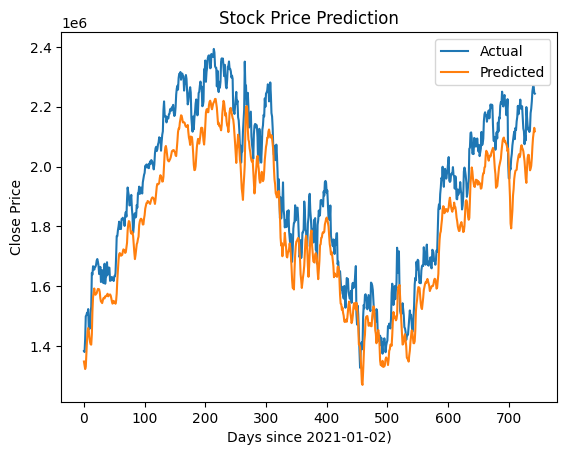

In [38]:
# Inverse transform the predictions to get the original scale
# Use the 'Close' feature scaler to inverse transform the predictions
predictions = close_scaler.inverse_transform(predictions)
test_y = close_scaler.inverse_transform(test_y.reshape(-1, 1))

plt.plot(test_y, label='Actual')
plt.xlabel('Days since 2021-01-02')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.savefig('stock_price_prediction.png')
plt.ion()
# plt.pause(100)